In [23]:
import spotipy
import pandas as pd
import numpy as np
from spotipy.oauth2 import SpotifyOAuth
import time

In [24]:
client_id='c4ff820f994745288df451ea7d6940d5'
client_secret='be2297719e5e4fb698f112c4374ee3b1'
redirect_uri='https://open.spotify.com/'
token_url = "https://accounts.spotify.com/api/token"

## Project Outline

- download a dataset of spotify playlists
- find or write a library to handle genre etc analysis
- group similar playlists
- use plotting techniques to show clusters?

Project Proposal:
I am personally interested in analyzing my longterm listening and curation history through Spotify and spotipy. I have an extensive collection of playlists, which due to their regularity, can be analyzed as objects. The intention of the analysis is to uncover trends in the groupings, visualize the relative distances (similarities) of songs within playlists, and create a prediction mechanism for most similar playlists. I will use sklearn, matplotlib, and seaborn for the clustering and visualizations.

## User Auth

In [152]:
scope = 'playlist-read-private'

sp_oauth = SpotifyOAuth(client_id=client_id,client_secret=client_secret,redirect_uri=redirect_uri,scope=scope)
token_info = sp_oauth.get_cached_token() 
if not token_info:
    auth_url = sp_oauth.get_authorize_url()
    print(auth_url)
    response = input('Paste the above link into your browser, then paste the redirect url here: ')

    code = sp_oauth.parse_response_code(response)
    token_info = sp_oauth.get_access_token(code)

    token = token_info['access_token']

sp = spotipy.Spotify(auth=token, retries=10, requests_timeout=10)

In [29]:
# scope = 'playlist-read-private'

# oauth = spotipy.util.prompt_for_user_token(client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri, scope=scope)
# sp = spotipy.Spotify(auth=oauth)

In [30]:
if sp:
    print(sp.me())

{'display_name': 'amaya lim', 'external_urls': {'spotify': 'https://open.spotify.com/user/nightrainlily'}, 'href': 'https://api.spotify.com/v1/users/nightrainlily', 'id': 'nightrainlily', 'images': [{'url': 'https://i.scdn.co/image/ab67757000003b82180bd1d0c567a1e26710aeb8', 'height': 64, 'width': 64}, {'url': 'https://i.scdn.co/image/ab6775700000ee85180bd1d0c567a1e26710aeb8', 'height': 300, 'width': 300}], 'type': 'user', 'uri': 'spotify:user:nightrainlily', 'followers': {'href': None, 'total': 362}}


## Getting Playlists

In [31]:
from time import sleep
from tqdm import tqdm, trange

In [46]:
def get_all_playlists():
    playlist_count = 1000
    results = []
    offset = 0
    pbar = tqdm(total=1000)
    while offset < playlist_count:
        results.append(sp.current_user_playlists(limit=50, offset=offset))
        time.sleep(10)
        pbar.update(50)
        offset += 50
    pbar.close()
    return results
results = get_all_playlists()











































100%|██████████| 1000/1000 [03:30<00:00,  4.74it/s]


In [47]:
def parse(playlist_json, target):
    lst = []
    for i in np.arange(len(playlist_json['items'])):
        target_value = playlist_json['items'][i]['track'][target]
        lst.append(target_value)
    return lst 

In [48]:
import re

playlist_data = []

for result in results:
    # pbar = tqdm(total=1000)
    for playlist in result['items']:
        reg = "^([0-9])+\s([a-z]+(\s?)([a-z]?))"
        # pbar.update(1)
        if re.search(reg, playlist['name']) != None:
            track_info = sp.playlist_tracks(playlist['id'], fields='items(track(id, name))')
            playlist_data.append({
                'name' : playlist['name'],
                'track_ids' : parse(track_info, 'id'),
                'track_names' : parse(track_info, 'name'),
                'id' : playlist['id'],
                'image' : playlist['images'][0]['url']
            })
    # pbar.close()

playlists = pd.DataFrame(playlist_data)
# playlists.head().style.format({'image': lambda x : f'<img src="{x}" width="100px"/>'})
# playlists.head()

In [49]:
def pretty_tracks(col, name):
        all_l = []
        for i in np.arange(len(playlists[col])):
                row = playlists[col].values[i]
                l = []
                for j in row:
                        for k in np.arange(len(row)):
                                track = item[k]['track']
                                id = track[name]
                                l.append(id)
                all_l.append(l)
        return all_l

# playlists['track_ids'] = pretty_tracks('track_ids', 'id')
# playlists['track_names'] = pretty_tracks('track_names', 'name')

# playlists.head().style.format({'image': lambda x : f'<img src="{x}" width="100px"/>'})
playlists.head()


,name,track_ids,track_names,id,image
0,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...
1,842 what did you expect,"[0rxQTgJzd0HCUk4QUxSkjK, 1EvFahLuLZ0vSVZo8YR3G...","[Even If It Hurts (feat. Blood Orange), Due We...",0KgwFInw8xWYmtDQWayf2p,https://mosaic.scdn.co/640/ab67616d00001e02145...
2,841 promise i'm better,"[12UQIJePnGeLmpVReYpG2w, 6ELP6nqqRDftftpjgioiW...","[Sunny day, Getting Older, Mutations, Le Templ...",6OrcGRAMqQ3A6o2zCmqTj5,https://mosaic.scdn.co/640/ab67616d00001e02384...
3,840 it falls apart,"[10cGyorRXoOc9RhVhY9Sru, 2TPy9mk2KVIwSXrqwgKk2...","[She's Leaving You, Warmest Part of the Winter...",2rARwXlp3rvRwTDnT6KXXu,https://mosaic.scdn.co/640/ab67616d00001e02012...
4,840 pretty woman,"[35tWhD29yvWwB0IDRr6zsL, 5sMEEjviCkH6Rp5X2ZvII...","[Yeah Right, Everything is romantic, Frank's T...",6T6cMAfk5OTqGcs3L1gUUU,https://image-cdn-ak.spotifycdn.com/image/ab67...


## Getting Song Data

In [57]:
songs = playlists
songs['zipp'] = list(zip(songs['track_ids'], songs['track_names']))

In [58]:
def merge(z):
    return list(tuple(zip(z[0], z[1])))

songs['zipp'] = songs['zipp'].apply(merge)
songs.head()

,name,track_ids,track_names,id,image,zipp
0,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"[(0uQo0HbOwXdPRGlNyFqGKi, You Never Knew), (3U..."
1,842 what did you expect,"[0rxQTgJzd0HCUk4QUxSkjK, 1EvFahLuLZ0vSVZo8YR3G...","[Even If It Hurts (feat. Blood Orange), Due We...",0KgwFInw8xWYmtDQWayf2p,https://mosaic.scdn.co/640/ab67616d00001e02145...,"[(0rxQTgJzd0HCUk4QUxSkjK, Even If It Hurts (fe..."
2,841 promise i'm better,"[12UQIJePnGeLmpVReYpG2w, 6ELP6nqqRDftftpjgioiW...","[Sunny day, Getting Older, Mutations, Le Templ...",6OrcGRAMqQ3A6o2zCmqTj5,https://mosaic.scdn.co/640/ab67616d00001e02384...,"[(12UQIJePnGeLmpVReYpG2w, Sunny day), (6ELP6nq..."
3,840 it falls apart,"[10cGyorRXoOc9RhVhY9Sru, 2TPy9mk2KVIwSXrqwgKk2...","[She's Leaving You, Warmest Part of the Winter...",2rARwXlp3rvRwTDnT6KXXu,https://mosaic.scdn.co/640/ab67616d00001e02012...,"[(10cGyorRXoOc9RhVhY9Sru, She's Leaving You), ..."
4,840 pretty woman,"[35tWhD29yvWwB0IDRr6zsL, 5sMEEjviCkH6Rp5X2ZvII...","[Yeah Right, Everything is romantic, Frank's T...",6T6cMAfk5OTqGcs3L1gUUU,https://image-cdn-ak.spotifycdn.com/image/ab67...,"[(35tWhD29yvWwB0IDRr6zsL, Yeah Right), (5sMEEj..."


In [59]:
songs = songs.explode('zipp')
songs.head()

,name,track_ids,track_names,id,image,zipp
0,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(0uQo0HbOwXdPRGlNyFqGKi, You Never Knew)"
0,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(3UY4s7F4Ard3T6vm7xcJxQ, Haircut)"
0,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(1HfsmNlg8xxhOr9N2i4Q0n, Touching Yourself)"
0,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(5ksM8r8u4AjMwvtqUif9W1, Slide Tackle)"
0,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(2IM2fs9rVuDbqtuXpycvam, rangerover - Bonus Tr..."


In [60]:
songs['track_name'] = songs['zipp'].map(lambda x: x[1])
songs['track_id'] = songs['zipp'].map(lambda x: x[0])
songs.head()

,name,track_ids,track_names,id,image,zipp,track_name,track_id
0,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(0uQo0HbOwXdPRGlNyFqGKi, You Never Knew)",You Never Knew,0uQo0HbOwXdPRGlNyFqGKi
0,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(3UY4s7F4Ard3T6vm7xcJxQ, Haircut)",Haircut,3UY4s7F4Ard3T6vm7xcJxQ
0,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(1HfsmNlg8xxhOr9N2i4Q0n, Touching Yourself)",Touching Yourself,1HfsmNlg8xxhOr9N2i4Q0n
0,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(5ksM8r8u4AjMwvtqUif9W1, Slide Tackle)",Slide Tackle,5ksM8r8u4AjMwvtqUif9W1
0,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(2IM2fs9rVuDbqtuXpycvam, rangerover - Bonus Tr...",rangerover - Bonus Track,2IM2fs9rVuDbqtuXpycvam


In [61]:
songs.reset_index()

,index,name,track_ids,track_names,id,image,zipp,track_name,track_id
0,0,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(0uQo0HbOwXdPRGlNyFqGKi, You Never Knew)",You Never Knew,0uQo0HbOwXdPRGlNyFqGKi
1,0,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(3UY4s7F4Ard3T6vm7xcJxQ, Haircut)",Haircut,3UY4s7F4Ard3T6vm7xcJxQ
2,0,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(1HfsmNlg8xxhOr9N2i4Q0n, Touching Yourself)",Touching Yourself,1HfsmNlg8xxhOr9N2i4Q0n
3,0,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(5ksM8r8u4AjMwvtqUif9W1, Slide Tackle)",Slide Tackle,5ksM8r8u4AjMwvtqUif9W1
4,0,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(2IM2fs9rVuDbqtuXpycvam, rangerover - Bonus Tr...",rangerover - Bonus Track,2IM2fs9rVuDbqtuXpycvam
...,...,...,...,...,...,...,...,...,...
9692,926,007 all this time // taste for the relevant,"[1DrlLvlYd1FIjNavRm6NdX, 15jNKKCmLjyGQnKzphBiO...","[Back Pocket, Front Tooth, Does It Feel Real, ...",2Gg4bWhMij2PXtI6AGvPPS,https://mosaic.scdn.co/640/ab67616d00001e0216a...,"(4YZbVct8l9MnAVIROnLQdx, Forrest Gump)",Forrest Gump,4YZbVct8l9MnAVIROnLQdx
9693,926,007 all this time // taste for the relevant,"[1DrlLvlYd1FIjNavRm6NdX, 15jNKKCmLjyGQnKzphBiO...","[Back Pocket, Front Tooth, Does It Feel Real, ...",2Gg4bWhMij2PXtI6AGvPPS,https://mosaic.scdn.co/640/ab67616d00001e0216a...,"(0DXlHWi8pqB5R2gfzlZx2i, No Better)",No Better,0DXlHWi8pqB5R2gfzlZx2i
9694,926,007 all this time // taste for the relevant,"[1DrlLvlYd1FIjNavRm6NdX, 15jNKKCmLjyGQnKzphBiO...","[Back Pocket, Front Tooth, Does It Feel Real, ...",2Gg4bWhMij2PXtI6AGvPPS,https://mosaic.scdn.co/640/ab67616d00001e0216a...,"(4M2t7bP4Mq87mGMn0PObUX, untitled 06 | 06.30.2...",untitled 06 | 06.30.2014.,4M2t7bP4Mq87mGMn0PObUX
9695,926,007 all this time // taste for the relevant,"[1DrlLvlYd1FIjNavRm6NdX, 15jNKKCmLjyGQnKzphBiO...","[Back Pocket, Front Tooth, Does It Feel Real, ...",2Gg4bWhMij2PXtI6AGvPPS,https://mosaic.scdn.co/640/ab67616d00001e0216a...,"(0ekkYaWO7OR9RBWtOcGPKM, Herringbone)",Herringbone,0ekkYaWO7OR9RBWtOcGPKM


In [71]:
songs = songs.dropna()

### Audio Features

In [80]:
def batch(lst, n):
    for i in range(0, len(lst), n):
        if len(lst) >= (i+n):
            yield lst[i:i + n]
        else:
            yield lst[i:]

def get_audio_features(uris):
    results = []
    pbar = tqdm(total=1000)
    batched = batch(uris, 100)
    for each in batched:
        results.append(sp.audio_features(each))
        pbar.update(50)
    pbar.close()
    return results

In [81]:
audio_features_results = get_audio_features(songs['track_id'])







































































































































































































































































































4850it [00:23, 203.02it/s]


In [309]:
unpacked = [song for hundred in audio_features_results for song in hundred]

In [310]:
features = pd.DataFrame(unpacked)
features.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.738,0.707,7,-5.966,1,0.0265,0.1430,0.000010,0.1050,0.808,117.999,audio_features,0uQo0HbOwXdPRGlNyFqGKi,spotify:track:0uQo0HbOwXdPRGlNyFqGKi,https://api.spotify.com/v1/tracks/0uQo0HbOwXdP...,https://api.spotify.com/v1/audio-analysis/0uQo...,269227,4
1,0.779,0.495,8,-7.621,1,0.0381,0.7310,0.000332,0.1320,0.546,128.992,audio_features,3UY4s7F4Ard3T6vm7xcJxQ,spotify:track:3UY4s7F4Ard3T6vm7xcJxQ,https://api.spotify.com/v1/tracks/3UY4s7F4Ard3...,https://api.spotify.com/v1/audio-analysis/3UY4...,216003,4
2,0.714,0.680,3,-5.989,1,0.0260,0.1350,0.000002,0.2290,0.934,108.001,audio_features,1HfsmNlg8xxhOr9N2i4Q0n,spotify:track:1HfsmNlg8xxhOr9N2i4Q0n,https://api.spotify.com/v1/tracks/1HfsmNlg8xxh...,https://api.spotify.com/v1/audio-analysis/1Hfs...,181587,4
3,0.746,0.603,5,-6.516,1,0.0297,0.0178,0.013900,0.0573,0.874,127.989,audio_features,5ksM8r8u4AjMwvtqUif9W1,spotify:track:5ksM8r8u4AjMwvtqUif9W1,https://api.spotify.com/v1/tracks/5ksM8r8u4AjM...,https://api.spotify.com/v1/audio-analysis/5ksM...,219783,4
4,0.634,0.654,4,-5.351,0,0.0547,0.0584,0.000000,0.1990,0.782,149.782,audio_features,2IM2fs9rVuDbqtuXpycvam,spotify:track:2IM2fs9rVuDbqtuXpycvam,https://api.spotify.com/v1/tracks/2IM2fs9rVuDb...,https://api.spotify.com/v1/audio-analysis/2IM2...,135703,4


In [311]:
songs_features = songs.merge(features,  left_on='track_id', right_on='id')
songs_features.head()

,name,track_ids,track_names,id_x,image,zipp,track_name,track_id,danceability,energy,...,liveness,valence,tempo,type,id_y,uri,track_href,analysis_url,duration_ms,time_signature
0,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(0uQo0HbOwXdPRGlNyFqGKi, You Never Knew)",You Never Knew,0uQo0HbOwXdPRGlNyFqGKi,0.738,0.707,...,0.105,0.808,117.999,audio_features,0uQo0HbOwXdPRGlNyFqGKi,spotify:track:0uQo0HbOwXdPRGlNyFqGKi,https://api.spotify.com/v1/tracks/0uQo0HbOwXdP...,https://api.spotify.com/v1/audio-analysis/0uQo...,269227,4
1,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(3UY4s7F4Ard3T6vm7xcJxQ, Haircut)",Haircut,3UY4s7F4Ard3T6vm7xcJxQ,0.779,0.495,...,0.132,0.546,128.992,audio_features,3UY4s7F4Ard3T6vm7xcJxQ,spotify:track:3UY4s7F4Ard3T6vm7xcJxQ,https://api.spotify.com/v1/tracks/3UY4s7F4Ard3...,https://api.spotify.com/v1/audio-analysis/3UY4...,216003,4
2,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(3UY4s7F4Ard3T6vm7xcJxQ, Haircut)",Haircut,3UY4s7F4Ard3T6vm7xcJxQ,0.779,0.495,...,0.132,0.546,128.992,audio_features,3UY4s7F4Ard3T6vm7xcJxQ,spotify:track:3UY4s7F4Ard3T6vm7xcJxQ,https://api.spotify.com/v1/tracks/3UY4s7F4Ard3...,https://api.spotify.com/v1/audio-analysis/3UY4...,216003,4
3,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(1HfsmNlg8xxhOr9N2i4Q0n, Touching Yourself)",Touching Yourself,1HfsmNlg8xxhOr9N2i4Q0n,0.714,0.680,...,0.229,0.934,108.001,audio_features,1HfsmNlg8xxhOr9N2i4Q0n,spotify:track:1HfsmNlg8xxhOr9N2i4Q0n,https://api.spotify.com/v1/tracks/1HfsmNlg8xxh...,https://api.spotify.com/v1/audio-analysis/1Hfs...,181587,4
4,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(1HfsmNlg8xxhOr9N2i4Q0n, Touching Yourself)",Touching Yourself,1HfsmNlg8xxhOr9N2i4Q0n,0.714,0.680,...,0.229,0.934,108.001,audio_features,1HfsmNlg8xxhOr9N2i4Q0n,spotify:track:1HfsmNlg8xxhOr9N2i4Q0n,https://api.spotify.com/v1/tracks/1HfsmNlg8xxh...,https://api.spotify.com/v1/audio-analysis/1Hfs...,181587,4


In [312]:
playlist_features = songs_features[['name', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']].groupby('name').median()
playlist_features.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
name,,,,,,,,,,,
00 all yours,0.583,0.569,7.0,-7.9775,1.0,0.03600,0.3700,0.000694,0.1110,0.5520,114.7475
00 alright,0.612,0.702,2.0,-5.7070,1.0,0.05280,0.0908,0.000022,0.0806,0.5020,122.8040
00 another dream,0.714,0.630,5.0,-6.3450,1.0,0.03630,0.1350,0.000007,0.1320,0.7775,115.9975
00 before you go,0.518,0.341,5.0,-9.0890,1.0,0.04115,0.6270,0.000000,0.1105,0.2330,124.1130
00 call it love,0.551,0.758,2.0,-7.3850,1.0,0.03520,0.0878,0.000099,0.0960,0.5470,118.0200


In [156]:
playlists.to_csv('playlists.csv', index=False)
songs.to_csv('songs.csv', index=False)
features.to_csv('features.csv', index=False)

### Feature Scaling and Engineering

In [485]:
X_e = playlist_features.copy().reset_index()

X_e = X_e.drop(['key', 'liveness'], axis=1)

In [486]:
pnames = X_e.pop('name')
for column in X_e.columns:
    X_e[column] = X_e[column] / X_e[column].abs().max()

X_e.head()

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo
0,0.727386,0.630820,-0.482578,1.0,0.122658,0.390295,0.000968,0.624788,0.694043
1,0.763568,0.778271,-0.345230,1.0,0.179898,0.095781,0.000030,0.568195,0.742772
2,0.890830,0.698448,-0.383824,1.0,0.123680,0.142405,0.000009,0.880023,0.701603
3,0.646288,0.378049,-0.549815,1.0,0.140204,0.661392,0.000000,0.263724,0.750690
4,0.687461,0.840355,-0.446736,1.0,0.119932,0.092616,0.000138,0.619128,0.713836


### PCA

In [487]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [488]:
pca = PCA(n_components=2)

pc = pd.DataFrame(pca.fit_transform(X_e))
pc.head()

,0,1
0,-0.062908,0.125885
1,-0.371697,0.251326
2,-0.389200,0.232861
3,0.361035,-0.024228
4,-0.365429,0.259910


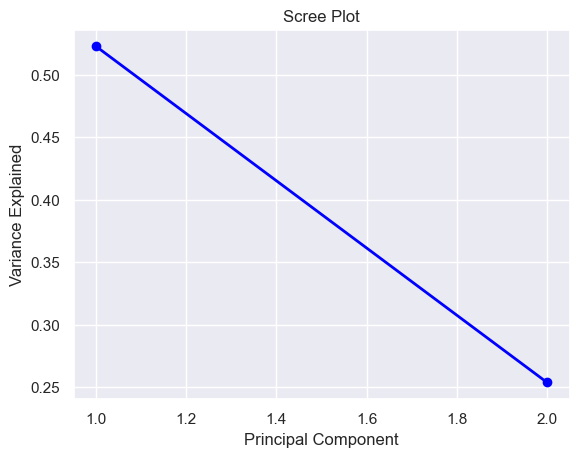

In [489]:
pc_vals = np.arange(pca.n_components_) + 1
plt.plot(pc_vals, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [490]:
loadings = pca.components_
n_features = pca.n_features_in_
feature_names = X_e.columns

pc_list = [f'PC{i}' for i in list(range(1, n_features + 1))]
pc_loadings = dict(zip(pc_list, loadings))

loadings_df = pd.DataFrame.from_dict(pc_loadings)
loadings_df['feature_names'] = feature_names
loadings_df = loadings_df.set_index('feature_names')
loadings_df

,PC1,PC2
feature_names,,
danceability,-0.147301,-0.047481
energy,-0.417942,0.168799
loudness,-0.303138,0.125156
mode,0.356963,0.921046
speechiness,-0.093730,-0.075085
acousticness,0.710322,-0.307657
instrumentalness,0.020022,-0.011859
valence,-0.265332,0.056643
tempo,-0.012945,0.040285


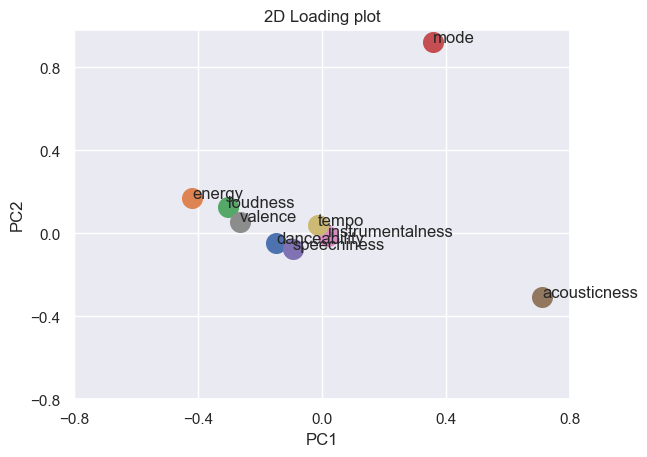

In [491]:
xs = loadings[0]
ys = loadings[1]

for i, varnames in enumerate(feature_names):
    plt.scatter(xs[i], ys[i], s=200)
    plt.text(xs[i], ys[i], varnames)

xticks = np.linspace(-0.8, 0.8, num=5)
yticks = np.linspace(-0.8, 0.8, num=5)
plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('2D Loading plot')
plt.show()

In [492]:
pc['name'] = playlist_features.index
pc.columns = ['pc1', 'pc2', 'name']
pc.head()

,pc1,pc2,name
0,-0.062908,0.125885,00 all yours
1,-0.371697,0.251326,00 alright
2,-0.389200,0.232861,00 another dream
3,0.361035,-0.024228,00 before you go
4,-0.365429,0.259910,00 call it love


### Clustering

In [493]:
from sklearn_extra.cluster import KMedoids as kmedoids
from sklearn.cluster import KMeans as kmeans
from sklearn.metrics import silhouette_score

In [494]:
# cluster_X = pd.concat([X, pc], axis=1, join='inner')

# X = playlist_features.drop(['key', 'mode', 'tempo', 'loudness'], axis=1).set_index('name')
X = pc.set_index('name')

In [495]:
s_scores = []

num_clusters = 1
low_score = -1
for i in range(2, 10):
    s = silhouette_score(X, kmedoids(n_clusters=i, random_state=42).fit_predict(X))
    s_scores.append(s)
    if s > low_score:
        low_score = s
        num_clusters = i

print(num_clusters)
print(s_scores)

4
[0.5066265432689315, 0.411110018682617, 0.5606477164027929, 0.514485898849564, 0.4917000301408745, 0.5193688603980537, 0.5104393802590559, 0.5168182350211119]


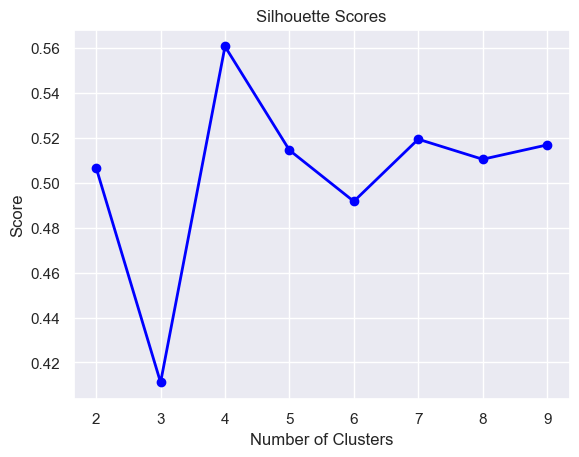

In [496]:
import matplotlib.pyplot as plt

plt.plot(range(2, 10), s_scores, 'o-', linewidth=2, color='blue')
plt.xticks(range(2, 10))
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.show()

In [497]:
km = kmedoids(n_clusters=4)
clusters = km.fit_predict(X)

clustered = X.copy()
clustered['cluster'] = clusters

In [498]:
cluster0 = clustered.loc[clustered['cluster'] == 0]
cluster0

,pc1,pc2,cluster
name,,,
00 before you go,0.361035,-0.024228,0
00 change,0.495679,-0.069151,0
00 deserve,0.415493,-0.021503,0
00 don't forget me,0.488862,-0.064842,0
00 don't say that you love me then make other plans,0.494171,-0.079777,0
...,...,...,...
817 can't believe,0.302818,-0.018841,0
819 love me to death,0.422143,-0.049914,0
828 more than i can give,0.597554,-0.131121,0


### Visualization

In [499]:
import seaborn as sns

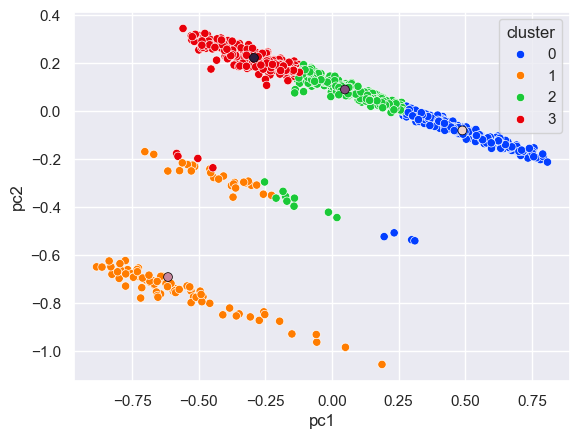

In [500]:
ax = sns.scatterplot(x='pc1', y='pc2', data=clustered, hue='cluster', palette='bright')
ax = sns.scatterplot(x= km.cluster_centers_[:, 0], y = km.cluster_centers_[:, 1], hue=range(num_clusters), s=40, ec='black', legend=False, ax=ax)

plt.show()

### Recommendation System

In [510]:
from scipy.spatial import distance_matrix
from sklearn.metrics.pairwise import euclidean_distances

In [504]:
def closest(df, centers):
    m = distance_matrix(centers, np.asmatrix(df.to_numpy()))
    return [df.index[i] for i in np.argmin(m, axis=1)]

centers = np.array(km.cluster_centers_)
closest(X, centers)

['339 euphoria', '236 what have i done', '196 thunder', '52 annie']

In [512]:
dists = euclidean_distances(km.cluster_centers_)
dists

array([[0.        , 1.26170987, 0.47231695, 0.8383234 ],
       [1.26170987, 0.        , 1.0248658 , 0.96842225],
       [0.47231695, 1.0248658 , 0.        , 0.36600647],
       [0.8383234 , 0.96842225, 0.36600647, 0.        ]])